In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
OLIGO_TABLE_PATH = '../data_tables/oligos_nonuniq_crispey3_GG_9bp_OLIGO_with_seq_primers.txt'
caff = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P7_CAFF_competitiontime_SCM_umi_level.tsv', sep = '\t')
p7_sc = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P7_SCM_competitiontime_SCM_umi_level.tsv', sep = '\t')
cocl = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P4_COCL_competitiontime_SCM_umi_level.tsv', sep = '\t')
p4_sc = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P4_SCM_competitiontime_SCM_umi_level.tsv',sep = '\t')
fluc = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P9_FLC_competitiontime_SCM_umi_level.tsv',sep = '\t')
p9_sc = pd.read_csv('../data_tables/Deseq_outputs/deseq2_res_bar_P9_SCM_competitiontime_SCM_umi_level.tsv',sep = '\t')



In [3]:
def romanToInt(s):
      """
      :type s: str
      :rtype: int
      """
      roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
      i = 0
      num = 0
      try:
          while i < len(s):
             if i+1<len(s) and s[i:i+2] in roman:
                num+=roman[s[i:i+2]]
                i+=2
             else:
                #print(i)
                num+=roman[s[i]]
                i+=1
          return num
      except:
        return s
      

In [4]:
oli_info = pd.read_csv(OLIGO_TABLE_PATH,'\t')
fluc['barcode_id'] =fluc.index.str.split('_').str[1:3].str.join('_')
p9_sc['barcode_id'] =p9_sc.index.str.split('_').str[1:3].str.join('_')
caff['barcode_id'] =caff.index.str.split('_').str[1:3].str.join('_')
p7_sc['barcode_id'] =p7_sc.index.str.split('_').str[1:3].str.join('_')
cocl['barcode_id'] =cocl.index.str.split('_').str[1:3].str.join('_')
p4_sc['barcode_id'] =p4_sc.index.str.split('_').str[1:3].str.join('_')
oli_info['chromosome'] = 'chromosome'+oli_info['chrom'].apply(romanToInt).astype(str)


/opt/sys/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (24,25,26,27,28,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
import numpy as np
from statsmodels.robust.scale import mad
from scipy.stats import ttest_ind, mannwhitneyu, kruskal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.formula.api import ols, wls
from statsmodels.stats.multitest import multipletests

def robust_outlier_removal(umi_df, fc_cutoff=3.5, basemean_cutoff=5):
    '''
    accepts a dataframe of deseq results and removes outliers based on log2FoldChange or baseMean values
    filters log2FoldChange by robust MADs - shrinks variance in logFC values
    filters baseMean by simple X-fold cutoff above median - reduces dependence on high leverage barcodes
    adjust cutoffs as necessary
    '''
    if len(umi_df)==1:
        return pd.DataFrame(index=umi_df.index)
    
    indices = umi_df.index.values
    fcs = umi_df['log2FoldChange'].values
    fc_outlier_stats = [abs(i-np.median(fcs))/mad(fcs) for i in fcs]
   
    
    outliers = []
    for i in range(len(indices)):
        if fc_outlier_stats[i]>fc_cutoff:
            outliers.append(indices[i])
    
    return umi_df.drop(outliers)

def calc_var_fitness(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks if the variant fitness effect 
    is significantly different from neutral in each condition (i.e. genotype/environment)
    '''
    # prep input
    conditions = sorted(conditions)
    test_names = []
    
    # build hypotheses
    covariates = lm.model.exog_names
    try:
        v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
        v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
        hyp = []
        for cond in conditions:
            # test if variant fitness effect is significantly different from zero
            test_names.append('{0},{1}'.format(v, cond))
            v_cond_cov = [c for c in v_cond_interactions if cond in c]
            # no interaction term if reference condition, else add interaction
            if len(v_cond_cov)==0: 
                hyp.append('{}=0'.format(v_cov))
            else:
                hyp.append('{}+{}=0'.format(v_cov, v_cond_cov[0])) # assumes each non-reference condition has only 1 term to add to calc fitness

        hyp = ','.join(hyp)

        # apply ttest and return result
        return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)
    except:
        print(v)

def calc_cond_interactions(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks between all conditions for significant interactions
    '''
    # prep input
    conditions = sorted(conditions)
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    test_names = []
    
    for i in range(len(conditions)-1):
        cond1 = conditions[i]
        v_cond1_cov = [c for c in v_cond_interactions if cond1 in c]
        if len(v_cond1_cov) == 0:
            v_cond1_cov = 0
        else:
            v_cond1_cov = v_cond1_cov[0]
        for j in range(i+1, len(conditions)):
            cond2 = conditions[j]
            v_cond2_cov = [c for c in v_cond_interactions if cond2 in c]
            if len(v_cond2_cov) == 0:
                v_cond2_cov = 0
            else:
                v_cond2_cov = v_cond2_cov[0]

            # add hypothesis test
            hyp.append('{0}={1}'.format(v_cond1_cov, v_cond2_cov))
            # add test name
            test_names.append('{0}:{1}-{2}'.format(v, cond1, cond2))

    hyp = ','.join(hyp)

    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)

def remove_outliers(df,title=None):
    fig, ax = plt.subplots()
    df.plot.scatter('baseMean', 'log2FoldChange', c = 'r', ax = ax)
    df2 = df.groupby('barcode_id').apply(robust_outlier_removal).droplevel('barcode_id')
    df2.plot.scatter('baseMean', 'log2FoldChange', c = 'black', ax = ax)
    ax.set_xscale('log')
    ax.set_title(title)
    return df2

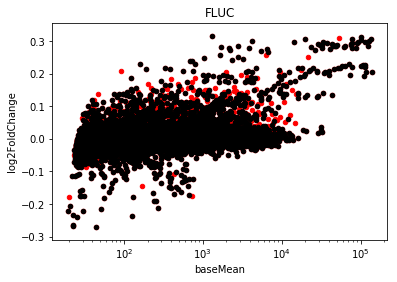

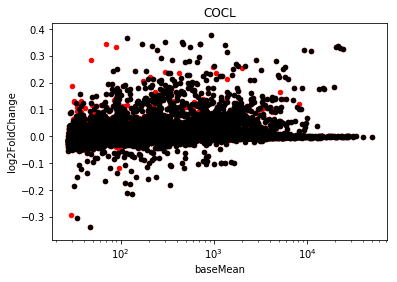

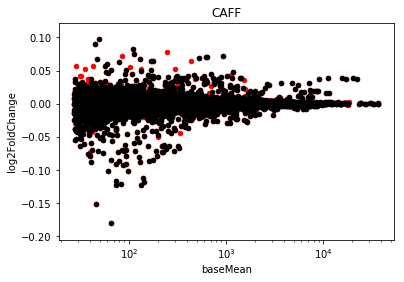

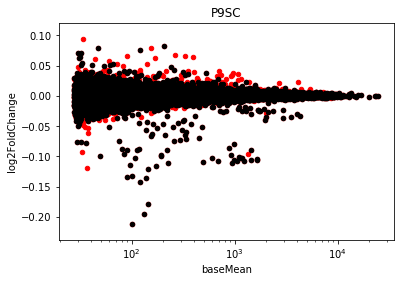

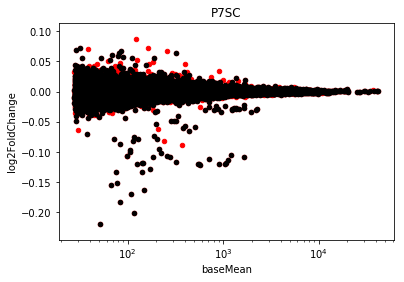

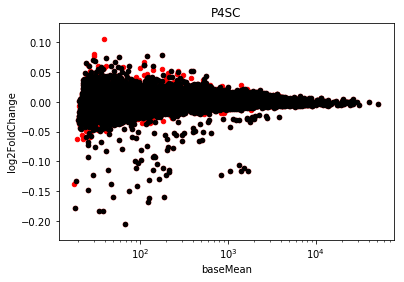

In [6]:
fluc_filt = remove_outliers(fluc, 'FLUC')
cocl_filt = remove_outliers(cocl, 'COCL')
caff_filt = remove_outliers(caff,'CAFF')
p9sc_filt = remove_outliers(p9_sc, 'P9SC')
p7sc_filt = remove_outliers(p7_sc, 'P7SC')
p4sc_filt = remove_outliers(p4_sc, 'P4SC')


In [7]:
fluc_filt['condition'] = 'FLUC'
cocl_filt['condition'] = 'COCL'
p9sc_filt['condition'] = 'P9SC'
p7sc_filt['condition'] = 'P7SC'
caff_filt['condition'] = 'CAFF'
p4sc_filt['condition'] = 'P4SC'


In [8]:
fluc_inf = fluc_filt.merge(oli_info, 'inner','barcode_id')
cocl_inf = cocl_filt.merge(oli_info, 'inner','barcode_id')
p4sc_inf = p4sc_filt.merge(oli_info, 'inner','barcode_id')
caff_inf = caff_filt.merge(oli_info, 'inner','barcode_id')
p7sc_inf = p7sc_filt.merge(oli_info, 'inner','barcode_id')

p9sc_inf = p9sc_filt.merge(oli_info, 'inner','barcode_id')

In [9]:
print(fluc_inf['barcode_id'].nunique())
print(cocl_inf['barcode_id'].nunique())
print(p4sc_inf['barcode_id'].nunique())
print(caff_inf['barcode_id'].nunique())
print(p7sc_inf['barcode_id'].nunique())

print(p9sc_inf['barcode_id'].nunique())

2291
2301
2334
2438
2471
2265


In [10]:
all_data_pool4 = pd.concat([p4sc_inf, cocl_inf])
all_data_pool7 =  pd.concat([p7sc_inf, caff_inf])
all_data_pool9 = pd.concat([p9sc_inf, fluc_inf])

Modeling neutral barcodes in FLUC


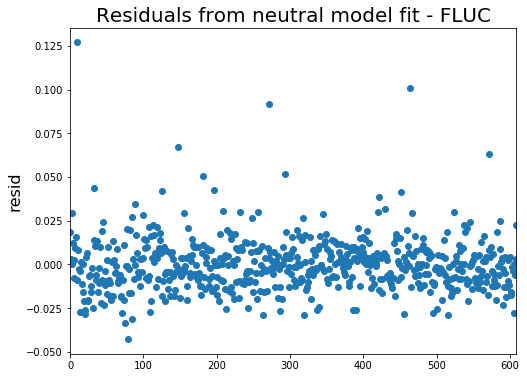

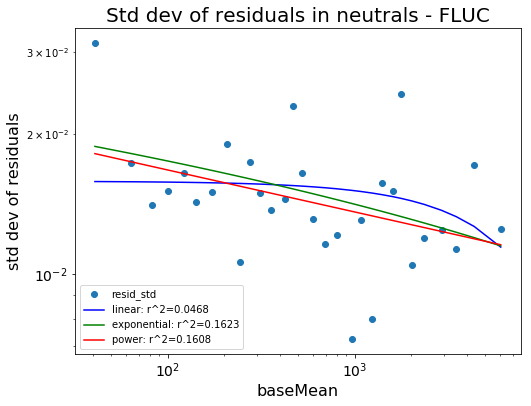

Selected model for FLUC: exponential
Formula: resid_std ~ np.log(baseMean)


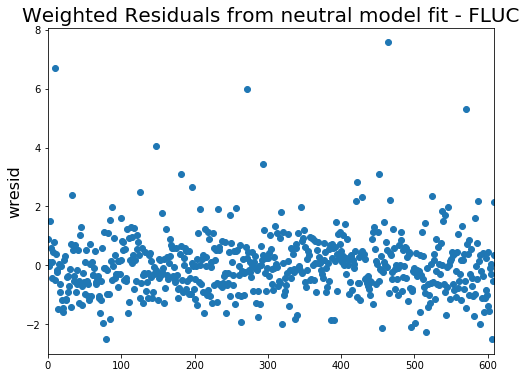

Modeling neutral barcodes in P9SC


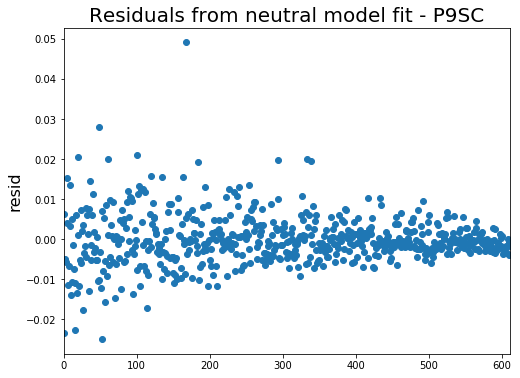

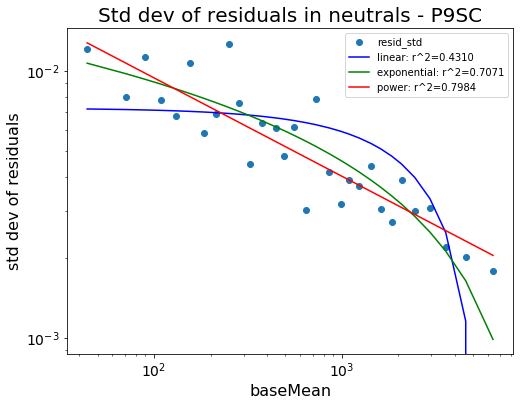

Selected model for P9SC: power
Formula: np.log(resid_std) ~ np.log(baseMean)


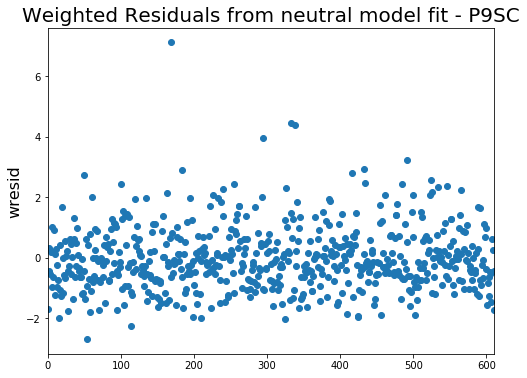

In [11]:
neutral_variance_model_dict = {}

for c, d_neutral in all_data_pool9[all_data_pool9['var_id'].str.startswith('neutral')].groupby('condition'):
    d_neutral = d_neutral.sort_values('baseMean').reset_index(drop=True)
    print('Modeling neutral barcodes in {}'.format(c))

    # fit OLS
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = ols(formula, d_neutral).fit()

    # plot residuals
    residuals = neutral_model.resid
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('resid', fontsize=16)
    ax.set_title('Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()

    # calculate standard deviations of residuals using rolling window of 20 barcodes
    window = 20
    residual_stds_df = pd.DataFrame.from_dict({'baseMean':d_neutral.sort_values('baseMean')['baseMean'].rolling(window).mean()[window-1::window],
                                               'resid_std':residuals.rolling(window).std()[window-1::window]})
    # find best fit for std deviation of residuals 
    fitted_models = {'linear' : ols(formula='resid_std ~ baseMean', data=residual_stds_df).fit(), 
                     'exponential' : ols(formula='resid_std ~ np.log(baseMean)', data=residual_stds_df).fit(), 
                     'power' : ols(formula='np.log(resid_std) ~ np.log(baseMean)', data=residual_stds_df).fit()}

    # plot std dev of residuals and fitted models
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot('baseMean', 'resid_std', data=residual_stds_df, marker='o', linestyle='')
    ax.plot(residual_stds_df['baseMean'], fitted_models['linear'].fittedvalues, 'b-', label='linear: r^2={:.4f}'.format(fitted_models['linear'].rsquared))
    ax.plot(residual_stds_df['baseMean'], fitted_models['exponential'].fittedvalues, 'g-', label='exponential: r^2={:.4f}'.format(fitted_models['exponential'].rsquared))
    ax.plot(residual_stds_df['baseMean'], np.exp(fitted_models['power'].fittedvalues), 'r-', label='power: r^2={:.4f}'.format(fitted_models['power'].rsquared))
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('std dev of residuals', fontsize=16)
    ax.set_title('Std dev of residuals in neutrals - {}'.format(c), fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # select model with best fit
    best_fit = max(fitted_models, key=lambda x: fitted_models[x].rsquared)
    print("Selected model for {}: {}".format(c, best_fit))
    std_model = fitted_models[best_fit]
    print("Formula:", std_model.model.formula)
#     display(std_model.summary())
    
    # calculate (inverse variance) weights based on fitted model, 
    if best_fit == "power":
        w = 1/np.exp(std_model.predict(d_neutral['baseMean']))**2
    else:
        w = 1/std_model.predict(d_neutral['baseMean'])**2

    # refit neutrals in WLS and inspect residuals
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = wls(formula, d_neutral, weights=w).fit()
    residuals = neutral_model.wresid[d_neutral.sort_values('baseMean').index]
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('wresid', fontsize=16)
    ax.set_title('Weighted Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()
    
    # store neutral model
    neutral_variance_model_dict[c] = (best_fit, std_model)

In [12]:
# prepare input data
d = all_data_pool9.copy()
d.loc[d['var_id'].str.startswith('neutral'), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference

# calculate weights using neutral models
d['weight'] = 1
for g in d['condition'].unique():
    fit_type, neutral_model = neutral_variance_model_dict[g]
    if fit_type == "power":
        d.loc[d['condition']==g, 'weight'] = 1 / np.exp(neutral_model.predict(d.loc[d['condition']==g]))**2
    else:
        d.loc[d['condition']==g, 'weight'] = 1 / neutral_model.predict(d.loc[d['condition']==g])**2
        
# for each oligo not in neutral set, set its associated barcodes' weights to the median weight
median_weights = d.loc[d['var_id']!=".NEUTRAL"].groupby(['condition', 'barcode_id'])['weight'].median()
d.loc[d['var_id']!=".NEUTRAL", "weight"] = d.loc[d['var_id']!=".NEUTRAL"].apply(lambda x: median_weights.loc[(x.condition, x.barcode_id)], axis=1)


In [13]:
# fit WLS
formula = 'log2FoldChange ~ C(var_id) + C(condition) + C(var_id):C(condition)'
wls_res = wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./pool9_wls_summary_FC.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()

In [14]:
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, cond_list) for var, cond_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'condition'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

var_fitness_df.to_csv('pool9_fitness_fc.tsv',sep = '\t')

,var_id,condition,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
1667,GXE_15504,FLUC,0.219959,0.002392,91.971015,0.000000e+00,0.215271,0.224647,0.000000e+00
1665,GXE_15503,FLUC,0.285940,0.002696,106.053904,0.000000e+00,0.280655,0.291225,0.000000e+00
1987,hdr_34,FLUC,0.208092,0.004369,47.628039,0.000000e+00,0.199528,0.216656,0.000000e+00
1950,hdr_14,P9SC,-0.126286,0.002784,-45.353482,0.000000e+00,-0.131744,-0.120829,0.000000e+00
422,GXE_00872,FLUC,0.171608,0.004029,42.588072,0.000000e+00,0.163710,0.179506,0.000000e+00
1648,GXE_15455,FLUC,0.194353,0.003647,53.285886,0.000000e+00,0.187204,0.201502,0.000000e+00
1703,GXE_15595,FLUC,0.289049,0.002408,120.030135,0.000000e+00,0.284329,0.293769,0.000000e+00
1943,hdr_10,P9SC,-0.102544,0.001113,-92.165396,0.000000e+00,-0.104724,-0.100363,0.000000e+00
1687,GXE_15561,FLUC,0.197602,0.003219,61.392698,0.000000e+00,0.191293,0.203911,0.000000e+00
1669,GXE_15506,FLUC,0.286767,0.003246,88.335117,0.000000e+00,0.280404,0.293130,0.000000e+00


In [15]:
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
gxe_df = pd.concat([calc_cond_interactions(var, wls_res, cond_list) for var, cond_list in var_dict.items() if len(cond_list)>=2], join='inner', axis=0)

# # adjust formatting
gxe_df.index = pd.MultiIndex.from_tuples(gxe_df.index.str.split(':').tolist(), names=['var_id', 'gxe'])


In [16]:
gxe_df = gxe_df.reset_index()
# calc padj
gxe_df = gxe_df.rename(columns={'P>|t|': 'pval'})
gxe_df['padj'] = multipletests(gxe_df['pval'], alpha=0.1, method='fdr_bh')[1]
display(gxe_df.sort_values('padj'))
gxe_df.to_csv('pool9_interaction_fc.tsv',sep = '\t')


,var_id,gxe,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
830,GXE_15561,FLUC-P9SC,0.197050,0.003537,55.705357,0.000000e+00,0.190116,0.203983,0.000000e+00
819,GXE_15503,FLUC-P9SC,0.287901,0.003704,77.736267,0.000000e+00,0.280642,0.295160,0.000000e+00
820,GXE_15504,FLUC-P9SC,0.220882,0.002697,81.891816,0.000000e+00,0.215596,0.226169,0.000000e+00
978,hdr_34,FLUC-P9SC,0.203475,0.004996,40.724934,0.000000e+00,0.193682,0.213268,0.000000e+00
811,GXE_15455,FLUC-P9SC,0.193212,0.004230,45.679745,0.000000e+00,0.184921,0.201502,0.000000e+00
838,GXE_15595,FLUC-P9SC,0.289966,0.003301,87.849680,0.000000e+00,0.283496,0.296435,0.000000e+00
821,GXE_15506,FLUC-P9SC,0.297180,0.005107,58.188296,0.000000e+00,0.287170,0.307191,0.000000e+00
208,GXE_00872,FLUC-P9SC,0.171273,0.004534,37.772786,1.963324e-302,0.162385,0.180160,2.542505e-300
679,GXE_14990,FLUC-P9SC,0.137432,0.003756,36.594757,1.541252e-284,0.130071,0.144793,1.774152e-282
804,GXE_15439,FLUC-P9SC,0.143474,0.004384,32.725203,2.580733e-229,0.134880,0.152067,2.673640e-227


Modeling neutral barcodes in CAFF


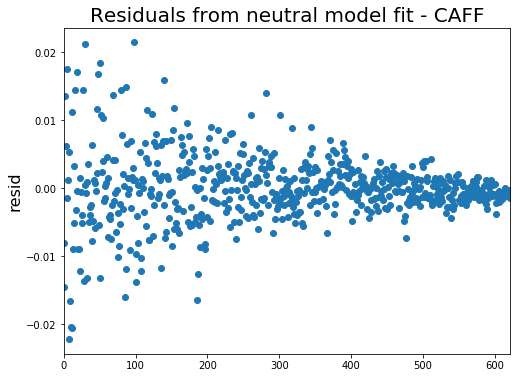

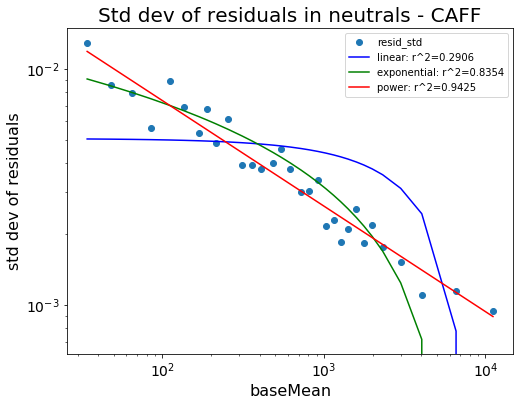

Selected model for CAFF: power
Formula: np.log(resid_std) ~ np.log(baseMean)


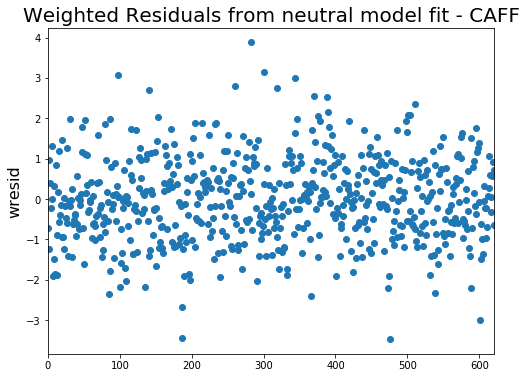

Modeling neutral barcodes in P7SC


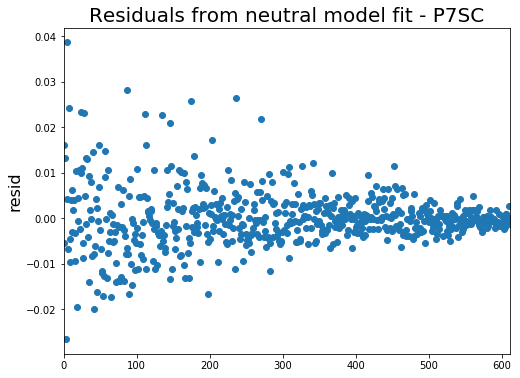

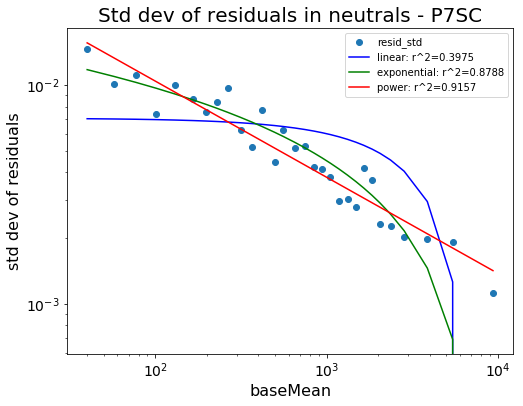

Selected model for P7SC: power
Formula: np.log(resid_std) ~ np.log(baseMean)


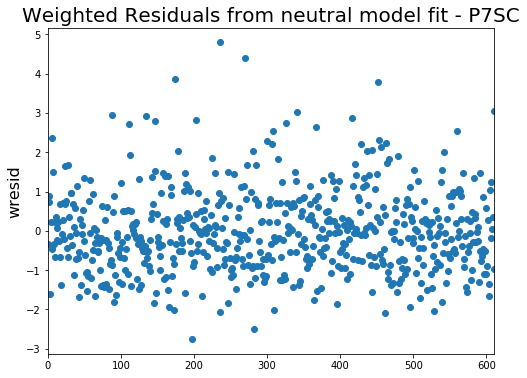

In [17]:
neutral_variance_model_dict = {}

for c, d_neutral in all_data_pool7[all_data_pool7['var_id'].str.startswith('neutral')].groupby('condition'):
    d_neutral = d_neutral.sort_values('baseMean').reset_index(drop=True)
    print('Modeling neutral barcodes in {}'.format(c))

    # fit OLS
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = ols(formula, d_neutral).fit()

    # plot residuals
    residuals = neutral_model.resid
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('resid', fontsize=16)
    ax.set_title('Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()

    # calculate standard deviations of residuals using rolling window of 20 barcodes
    window = 20
    residual_stds_df = pd.DataFrame.from_dict({'baseMean':d_neutral.sort_values('baseMean')['baseMean'].rolling(window).mean()[window-1::window],
                                               'resid_std':residuals.rolling(window).std()[window-1::window]})
    # find best fit for std deviation of residuals 
    fitted_models = {'linear' : ols(formula='resid_std ~ baseMean', data=residual_stds_df).fit(), 
                     'exponential' : ols(formula='resid_std ~ np.log(baseMean)', data=residual_stds_df).fit(), 
                     'power' : ols(formula='np.log(resid_std) ~ np.log(baseMean)', data=residual_stds_df).fit()}

    # plot std dev of residuals and fitted models
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot('baseMean', 'resid_std', data=residual_stds_df, marker='o', linestyle='')
    ax.plot(residual_stds_df['baseMean'], fitted_models['linear'].fittedvalues, 'b-', label='linear: r^2={:.4f}'.format(fitted_models['linear'].rsquared))
    ax.plot(residual_stds_df['baseMean'], fitted_models['exponential'].fittedvalues, 'g-', label='exponential: r^2={:.4f}'.format(fitted_models['exponential'].rsquared))
    ax.plot(residual_stds_df['baseMean'], np.exp(fitted_models['power'].fittedvalues), 'r-', label='power: r^2={:.4f}'.format(fitted_models['power'].rsquared))
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('std dev of residuals', fontsize=16)
    ax.set_title('Std dev of residuals in neutrals - {}'.format(c), fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # select model with best fit
    best_fit = max(fitted_models, key=lambda x: fitted_models[x].rsquared)
    print("Selected model for {}: {}".format(c, best_fit))
    std_model = fitted_models[best_fit]
    print("Formula:", std_model.model.formula)
#     display(std_model.summary())
    
    # calculate (inverse variance) weights based on fitted model, 
    if best_fit == "power":
        w = 1/np.exp(std_model.predict(d_neutral['baseMean']))**2
    else:
        w = 1/std_model.predict(d_neutral['baseMean'])**2

    # refit neutrals in WLS and inspect residuals
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = wls(formula, d_neutral, weights=w).fit()
    residuals = neutral_model.wresid[d_neutral.sort_values('baseMean').index]
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('wresid', fontsize=16)
    ax.set_title('Weighted Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()
    
    # store neutral model
    neutral_variance_model_dict[c] = (best_fit, std_model)

In [18]:
# prepare input data
d = all_data_pool7.copy()
d.loc[d['var_id'].str.startswith('neutral'), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference

# calculate weights using neutral models
d['weight'] = 1
for g in d['condition'].unique():
    fit_type, neutral_model = neutral_variance_model_dict[g]
    if fit_type == "power":
        d.loc[d['condition']==g, 'weight'] = 1 / np.exp(neutral_model.predict(d.loc[d['condition']==g]))**2
    else:
        d.loc[d['condition']==g, 'weight'] = 1 / neutral_model.predict(d.loc[d['condition']==g])**2
        
# for each oligo not in neutral set, set its associated barcodes' weights to the median weight
median_weights = d.loc[d['var_id']!=".NEUTRAL"].groupby(['condition', 'barcode_id'])['weight'].median()
d.loc[d['var_id']!=".NEUTRAL", "weight"] = d.loc[d['var_id']!=".NEUTRAL"].apply(lambda x: median_weights.loc[(x.condition, x.barcode_id)], axis=1)


In [19]:
# fit WLS
formula = 'log2FoldChange ~ C(var_id) + C(condition) + C(var_id):C(condition)'
wls_res = wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./pool7_wls_summary_fc.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()

In [ ]:
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, cond_list) for var, cond_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'condition'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

var_fitness_df.to_csv('pool7_fitness_fc.tsv',sep = '\t')

In [ ]:
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
gxe_df = pd.concat([calc_cond_interactions(var, wls_res, cond_list) for var, cond_list in var_dict.items() if len(cond_list)>=2], join='inner', axis=0)

# # adjust formatting
gxe_df.index = pd.MultiIndex.from_tuples(gxe_df.index.str.split(':').tolist(), names=['var_id', 'gxe'])


In [ ]:
gxe_df = gxe_df.reset_index()
# calc padj
gxe_df = gxe_df.rename(columns={'P>|t|': 'pval'})
gxe_df['padj'] = multipletests(gxe_df['pval'], alpha=0.1, method='fdr_bh')[1]
display(gxe_df.sort_values('padj'))
gxe_df.to_csv('pool7_interaction_fc.tsv',sep = '\t')


In [ ]:
neutral_variance_model_dict = {}

for c, d_neutral in all_data_pool4[all_data_pool4['var_id'].str.startswith('neutral')].groupby('condition'):
    d_neutral = d_neutral.sort_values('baseMean').reset_index(drop=True)
    print('Modeling neutral barcodes in {}'.format(c))

    # fit OLS
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = ols(formula, d_neutral).fit()

    # plot residuals
    residuals = neutral_model.resid
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('resid', fontsize=16)
    ax.set_title('Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()

    # calculate standard deviations of residuals using rolling window of 20 barcodes
    window = 20
    residual_stds_df = pd.DataFrame.from_dict({'baseMean':d_neutral.sort_values('baseMean')['baseMean'].rolling(window).mean()[window-1::window],
                                               'resid_std':residuals.rolling(window).std()[window-1::window]})
    # find best fit for std deviation of residuals 
    fitted_models = {'linear' : ols(formula='resid_std ~ baseMean', data=residual_stds_df).fit(), 
                     'exponential' : ols(formula='resid_std ~ np.log(baseMean)', data=residual_stds_df).fit(), 
                     'power' : ols(formula='np.log(resid_std) ~ np.log(baseMean)', data=residual_stds_df).fit()}

    # plot std dev of residuals and fitted models
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot('baseMean', 'resid_std', data=residual_stds_df, marker='o', linestyle='')
    ax.plot(residual_stds_df['baseMean'], fitted_models['linear'].fittedvalues, 'b-', label='linear: r^2={:.4f}'.format(fitted_models['linear'].rsquared))
    ax.plot(residual_stds_df['baseMean'], fitted_models['exponential'].fittedvalues, 'g-', label='exponential: r^2={:.4f}'.format(fitted_models['exponential'].rsquared))
    ax.plot(residual_stds_df['baseMean'], np.exp(fitted_models['power'].fittedvalues), 'r-', label='power: r^2={:.4f}'.format(fitted_models['power'].rsquared))
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('std dev of residuals', fontsize=16)
    ax.set_title('Std dev of residuals in neutrals - {}'.format(c), fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # select model with best fit
    best_fit = max(fitted_models, key=lambda x: fitted_models[x].rsquared)
    print("Selected model for {}: {}".format(c, best_fit))
    std_model = fitted_models[best_fit]
    print("Formula:", std_model.model.formula)
#     display(std_model.summary())
    
    # calculate (inverse variance) weights based on fitted model, 
    if best_fit == "power":
        w = 1/np.exp(std_model.predict(d_neutral['baseMean']))**2
    else:
        w = 1/std_model.predict(d_neutral['baseMean'])**2

    # refit neutrals in WLS and inspect residuals
    formula = 'log2FoldChange ~ np.log(baseMean)'
    neutral_model = wls(formula, d_neutral, weights=w).fit()
    residuals = neutral_model.wresid[d_neutral.sort_values('baseMean').index]
    fig, ax = plt.subplots(figsize=(8,6))
    residuals.plot(ax=ax, marker='o', linestyle='')
    ax.set_ylabel('wresid', fontsize=16)
    ax.set_title('Weighted Residuals from neutral model fit - {}'.format(c), fontsize=20)
    plt.show()
    
    # store neutral model
    neutral_variance_model_dict[c] = (best_fit, std_model)
# prepare input data
d = all_data_pool4.copy()
d.loc[d['var_id'].str.startswith('neutral'), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference

# calculate weights using neutral models
d['weight'] = 1
for g in d['condition'].unique():
    fit_type, neutral_model = neutral_variance_model_dict[g]
    if fit_type == "power":
        d.loc[d['condition']==g, 'weight'] = 1 / np.exp(neutral_model.predict(d.loc[d['condition']==g]))**2
    else:
        d.loc[d['condition']==g, 'weight'] = 1 / neutral_model.predict(d.loc[d['condition']==g])**2
        
# for each oligo not in neutral set, set its associated barcodes' weights to the median weight
median_weights = d.loc[d['var_id']!=".NEUTRAL"].groupby(['condition', 'barcode_id'])['weight'].median()
d.loc[d['var_id']!=".NEUTRAL", "weight"] = d.loc[d['var_id']!=".NEUTRAL"].apply(lambda x: median_weights.loc[(x.condition, x.barcode_id)], axis=1)
# fit WLS
formula = 'log2FoldChange ~ C(var_id) + C(condition) + C(var_id):C(condition)'
wls_res = wls(formula, data=d, weights=d['weight']).fit()
# display(wls_res.summary())

# write WLS model summary table to file
file = open("./pool4_wls_summary_fc.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()    
var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, cond_list) for var, cond_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'condition'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

var_fitness_df.to_csv('pool4_fitness_fc.tsv',sep = '\t')

var_dict = dict(d[d['var_id']!= '.NEUTRAL'].groupby('var_id').apply(lambda x: list(x.condition.unique())) )
gxe_df = pd.concat([calc_cond_interactions(var, wls_res, cond_list) for var, cond_list in var_dict.items() if len(cond_list)>=2], join='inner', axis=0)

# # adjust formatting
gxe_df.index = pd.MultiIndex.from_tuples(gxe_df.index.str.split(':').tolist(), names=['var_id', 'gxe'])

gxe_df = gxe_df.reset_index()
# calc padj
gxe_df = gxe_df.rename(columns={'P>|t|': 'pval'})
gxe_df['padj'] = multipletests(gxe_df['pval'], alpha=0.1, method='fdr_bh')[1]
display(gxe_df.sort_values('padj'))
gxe_df.to_csv('pool4_interaction_fc.tsv',sep = '\t')